# Deutsch's algorithm
Introduction: The purpose of this exercise is to understand the concept of "quantum advantage" by running Deutsch's algorithm, one of the simplest for which quantum computation outperforms classical computation.

Problem statement: <font color="blue"> $f:\{0,1\}\to \{0,1\}$ </font> is a "Boolean function", i.e. a function with domain a binary value and image another binary value. <font color="blue"> We want to know whether $f$ is or not a constant function.</blue>

To answer this question with a classical computer, we need to evaluate $f$ twice, e.g. we need to compute $f(0)$ and $f(1)$ and check whether $f(0)=f(1)$ or not. Deutsch's algorithm is a quantum algorithm that allows us to answer this question by evaluating $f$ only once!

### PREAMBLE:

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import Aer
from qiskit.visualization import *
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp, Operator
import numpy as np
from numpy import sqrt as sqrt

In [2]:
# Number of shots (repetitions of the program)
shots_S=100 #simulation()

# Simulator backend
sim = Aer.get_backend('aer_simulator') 

### Working mechanism of the Deutsch's algorithm (Oracles)

To encode the action of a Boolean fuction, the Deutsch's algorithm uses the following operation over two qubits

$$
|x\rangle|y\rangle\to |x\rangle|y\oplus f(x)\rangle
$$

where $\oplus$ denotes the binary addition (i.e. the addition mod. 2).

#### <font color=teal> **Homework 1** (to do later after the lab on pen and paper): <br>  Prove that this is a unitary operation. </font>

Hence, there exists a unitary operator $U_f$, which implements this operation on a quantum circuit. This unitary operator is called a *quantum oracle*. Now, since 

$$
|x\rangle|0\rangle \to |x\rangle|f(x)\rangle,
$$

the classical solution to the problem is equivalent to applying the quantum oracle to the states $|0\rangle|0\rangle$ and $|1\rangle|0\rangle$, followed by measuring the second qubit to retrieve first $f(0)$ and then $f(1)$, needing two oracle calls. In the following line, two oracle operators are defined for two respective functions $f$ and $g$, one is constant and the other is not:


In [3]:
Oracle_f = Operator([[0,0,1,0],[0,1,0,0],[1,0,0,0],[0,0,0,1]])
Oracle_g = Operator([[0,0,1,0],[0,0,0,1],[1,0,0,0],[0,1,0,0]])

(The Operator() command in Qiskit takes a matrix and will allow you to create a gate for a quantum circuit)

#### <font color=teal> **Question 2**: Complete the following cells to create quantum circuits for Oracle_f that decides whether $f$ is (or not) constant using the classical method with two evaluations </font>

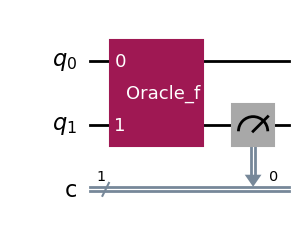

In [77]:
#Classical check Oracle_f: f(0)
Check_f0 = QuantumCircuit(2,1)
#Remember that by default the two qubits are initialized to zero
Check_f0.unitary(Oracle_f, [0, 1],label="Oracle_f")  # Apply Oracle_f
# Measure qubit 1
Check_f0.measure(1,0)
Check_f0.draw(output='mpl')

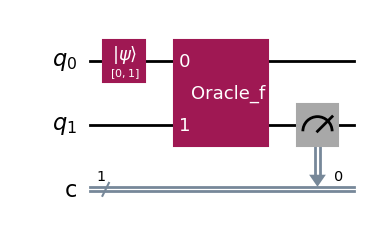

In [82]:
##Classical check Oracle_f: f(1)
Check_f1 = QuantumCircuit(2,1)
#We initialize the first qubit to 1:
Check_f1.initialize([0,1],0)
Check_f1.unitary(Oracle_f, [0, 1],label="Oracle_f")  # Apply Oracle_f
# Measure qubit 1
Check_f1.measure(1,0)
Check_f1.draw(output='mpl')

### Run the quantum circuits on a classical computer (the simulation machine) to obtain the values of $f(0)$ and $f(1)$

In [80]:
# One shot gor each circuit
shots_C=1
# Sampler with aer simulator as backend
sampler_S = Sampler(mode=sim);
# The sampler evaluates probabilities of each input circuit
jobs_f = sampler_S.run([Check_f0,Check_f1],shots=shots_C).result();
result_f_0 = jobs_f[0].data.c.get_counts() # result of Check_f0 circuit
result_f_1 = jobs_f[1].data.c.get_counts() # result of Check_f1 circuit

#### <font color=teal> **Question 3**: By printing "result_f_0" and "result_f_1", explain why the following cell gives the calculated result for $f(0)$ and $f(1)$. </font>

In [81]:
#Print the measurement results
print(f"f(0)={max(result_f_0)}") 
print(f"f(1)={max(result_f_1)}")

f(0)=1
f(1)=0


#### <font color=teal> **Question 4**: Complete the following cells to create quantum circuits for Oracle_g that solve the problem for $g$ using the classical method of two evaluations </font>

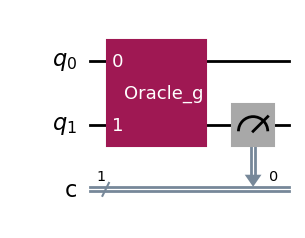

In [83]:
#Classical check Oracle_g: g(0)
Check_g0 = QuantumCircuit(2,1)
Check_g0.unitary(Oracle_g, [0, 1],label="Oracle_g")  # Apply Oracle_g
# Measure qubit 1
Check_g0.measure(1,0)
Check_g0.draw(output='mpl')

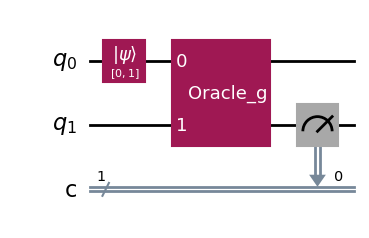

In [87]:
##Classical check Oracle_g: g(1)
Check_g1 = QuantumCircuit(2,1)
#We initialize the first qubit to 1:
Check_g1.initialize([0,1],0)
Check_g1.unitary(Oracle_g, [0, 1],label="Oracle_g")  # Apply Oracle_f
# Measure qubit 1
Check_g1.measure(1,0)
Check_g1.draw(output='mpl')

### Run the quantum circuits on a classical computer (the simulation machine) to obtain the values of $g(0)$ and $g(1)$

In [88]:
jobs_g = sampler_S.run([Check_g0,Check_g1],shots=shots_S);
result_g_0 = jobs_g.result()[0].data.c.get_counts()
result_g_1 = jobs_g.result()[1].data.c.get_counts()

In [89]:
#Print the measurement results
print(f"g(0)={max(result_g_0)}")
print(f"g(1)={max(result_g_1)}")

g(0)=1
g(1)=1


### Working mechanism of the Deutsch's algorithm 

The idea of Deutsch's algorithm is based on the use of quantum superposition to attempt a simultaneous evaluation of $f(0)$ and $f(1)$ with a single action of the quantum oracle. 

Actually, what the algorithm evaluates is $f(0)\ominus f(1)$ ($\ominus$ is substraction mod. 2, i.e. $1-1 = 0$, $0-1 = 1 = 1-0$) without individually evaluating $f(0)$ and $f(1)$. This means that $f(0)\ominus f(1)=0$ if $f$ is constant and $f(0)\ominus f(1)=1$ if not. This is achieved by applying the oracle to the state $|+\rangle|-\rangle$ with $|\pm\rangle=\tfrac{1}{\sqrt{2}}(|0\rangle\pm |1\rangle)$:

$$
|+\rangle|-\rangle=\frac{1}{2}\big(|0\rangle|0\rangle-|0\rangle|1\rangle+|1\rangle|0\rangle-|1\rangle|1\rangle\big)\to \frac{1}{2}\big[|0\rangle|f(0)\rangle-|0\rangle|1\oplus f(0)\rangle+|1\rangle|f(1)\rangle-|1\rangle|1\oplus f(1)\rangle\big]
$$

If $f(0)=f(1)$,

$$
\frac{1}{2}\big[|0\rangle|f(0)\rangle-|0\rangle|1\oplus f(0)\rangle+|1\rangle|f(0)\rangle-|1\rangle|1\oplus f(0)\rangle\big]=\frac{1}{2}\big[\big(|0\rangle+|1\rangle\big)|f(0)\rangle-\big(|0\rangle+|1\rangle\big)|1\oplus f(0)\rangle\big]=|+\rangle \left[\frac{|f(0)\rangle-|1\oplus f(0)\rangle}{\sqrt{2}}\right]
$$

#### <font color=teal> **Homework question 5**: Prove (after the lab, on pen and paper): </font>
<font color=teal>
if $f(0)\neq f(1)$, the final state becomes: </font>
    
$$
|-\rangle \left[\frac{|f(0)\rangle-|f(1)\rangle}{\sqrt{2}}\right].
$$ 
    
Therefore, after the oracle we apply a gate on the first qubit that makes the transformation $|+\rangle\to |0\rangle$ and $|-\rangle\to |1\rangle$ and measure it. When the answer is $0$, $f$ is constant and viceversa.

#### <font color=teal> **Question 6**: Define a quantum circuit to implement Deutsch's algorithm with the function $f$ and another with the function $g$ </font>

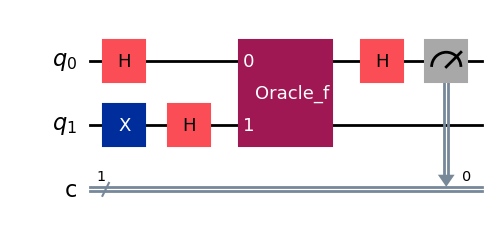

In [92]:
# Deutsch's for f
deutsch_f = QuantumCircuit(2,1)
deutsch_f.x(1)  # Apply X gate to qubit 0
deutsch_f.h([0, 1])  # Apply Hadamard gate to both qubits
deutsch_f.unitary(Oracle_f, [0, 1],label="Oracle_f")  # Apply Oracle_f
deutsch_f.h(0)  # Apply Hadamard gate to qubit 0

# Measure qubit 0
deutsch_f.measure(0,0)
deutsch_f.draw(output='mpl')

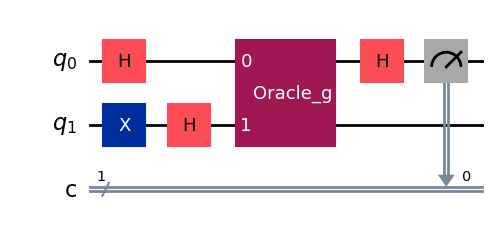

In [93]:
# Deutsch's for g
deutsch_g = QuantumCircuit(2,1)
deutsch_g.x(1)  # Apply X gate to qubit 0
deutsch_g.h([0, 1])  # Apply Hadamard gate to both qubits
deutsch_g.unitary(Oracle_g, [0, 1],label="Oracle_g")  # Apply Oracle_g
deutsch_g.h(0)  # Apply Hadamard gate to qubit 0
# Measure qubit 0
deutsch_g.measure(0,0)
deutsch_g.draw(output='mpl')

Let us execute these circuits on a free simulator

In [97]:
# Execute the circuit 
jobs_DeutschS=sampler_S.run([deutsch_f,deutsch_g],shots=shots_S).result() # one entry for each function
result_DeutschS_f = jobs_DeutschS[0].data.c.get_counts()
result_DeutschS_g = jobs_DeutschS[1].data.c.get_counts()

In [98]:
# Print the measurement results for f, if 0 the fuction is constant
if max(result_DeutschS_f)=='0':
    print("f is constant")
else:
    print("f is not constant")


f is not constant


In [99]:
# Print the measurement results for g, if 0 the fuction is constant
if max(result_DeutschS_g)=='0':
    print("g is constant")
else:
    print("g is not constant")

g is constant


### Run the quantum circuits on a real quantum machine

IBM offers free computation time accesible throught the cloud, each account is able to generate "user tokens" that allow to send "jobs" to real quantum hardware:

Please copy your token number here (to generate it see instructions in the pdf)

In [100]:
My_user_token = "b9968ad2d40bcf52dc390f83272649228d8fbb847bc6d72190e27e1f4bbeabf1c8f422151cc4ea587452529d7cbbb1ac3dfd527b2f917b18c18e073accd7bdb3" # Use this at home (long waiting time

##### Defining the quantum backend

In [101]:
# Quantum machine
Quantum_service = QiskitRuntimeService(channel="ibm_quantum",token=My_user_token)

First we have to choose one of the available machines

In [102]:
backend_Q = Quantum_service.least_busy(operational=True, simulator=False, min_num_qubits=100)

In [103]:
backend_Q.status()

##### Sending jobs to the machine

In [104]:
shots_Q=3
sampler_Q = Sampler(mode=backend_Q) #to obtain the sampling of the measurement 
# Execute the circuit 
job_Q=sampler_Q.run([transpile(deutsch_f,backend_Q),transpile(deutsch_g,backend_Q)],shots=shots_Q)

##### Checking job state

In [116]:
# The following cell gives information about the job
job_Q.status() # Status

'DONE'

In [106]:
job_Q.job_id() # Identification code

'czv4gdhkzhn0008cpnmg'

##### Retrieving job and results

Instead of waiting for the answer of recent jobs, we can use already completed ones if we now their job numbes, which can be found in the IBM quantum webpage

In [122]:
job_number = "czv4gdhkzhn0008cpnmg"

In [123]:
job =  Quantum_service.job(job_number)

In [124]:
result = job.result()

In [125]:
# Print the measurement results for f, if 0 the fuction is constant
if max(result[0].data.c.get_counts())=='0':
    print("f is constant")
else:
    print("f is not constant")


f is not constant


In [126]:
# Print the measurement results for g, if 0 the fuction is constant
if max(result[1].data.c.get_counts())=='0':
    print("g is constant")
else:
    print("g is not constant")

g is constant


#### <font color=teal> **Question 7**: Does the result of your quantum computation using Deutsch's algorithm agree with the previous classical result?